In [1]:
import pandas as pd
import polars as pl
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.width', 150)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
sns.set()

In [2]:
dates = ['session_start', 'session_end', 'session_date', 'order_dt']
df = pd.read_csv('ecom_go_2.csv', parse_dates=dates)
df_pl = pl.from_pandas(df)

print(df.shape)
print(df.columns.tolist())

(1009, 19)
['user_id', 'region', 'device', 'channel', 'session_start', 'session_end', 'sessiondurationsec', 'session_date', 'month', 'day', 'hour_of_day', 'order_dt', 'revenue', 'payment_type', 'promo_code', 'final_price', 'time_of_day', 'payer', 'week']


In [3]:
df_unchanged = df.copy()
print(df_unchanged.shape, df_unchanged['payer'].sum())

df_replaced = df.copy()
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 100000, 9999, df_replaced['revenue'])
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 1, 4999, df_replaced['revenue'])
print(df_replaced.shape, df_replaced['payer'].sum())

df_removed = df.copy()
to_remove = df[df['revenue'].isin([1, 100000])].index
df_removed.drop(to_remove, inplace=True)
print(df_removed.shape, df_removed['payer'].sum())


dfs = [(df_unchanged, "ORIGINAL DATAFRAME:"), 
       (df_replaced, "REPLACED DATAFRAME:"), 
       (df_removed, "REMOVED DATAFRAME:")]

(1009, 19) 282
(1009, 19) 282
(1003, 19) 276


In [107]:
CHANNEL_COST_HIERARCHY = {
    'контекстная реклама': 4,
    'социальные сети': 3,
    'реклама у блогеров': 2,
    'email-рассылки': 1,
    'organic': 0
}

### `Conversion Rate by Channel`

In [108]:
def analyze_channel_conversion(df):
    unique_paying_users = df[df['payer'] == 1].groupby('channel')['user_id'].nunique()
    total_unique_users = df.groupby('channel')['user_id'].nunique()
    
    channel_metrics = pd.DataFrame({
        'total_unique_users': total_unique_users,
        'unique_paying_users': unique_paying_users,
        'total_revenue': df.groupby('channel')['revenue'].sum()
    })
    
    channel_metrics['channel_cost_score'] = channel_metrics.index.map(CHANNEL_COST_HIERARCHY)
    channel_metrics['conversion_rate'] = (
        channel_metrics['unique_paying_users'] / channel_metrics['total_unique_users'] * 100
    ).round(1)
    channel_metrics['efficiency_score'] = (
        channel_metrics['conversion_rate'] / (channel_metrics['channel_cost_score'] + 1)
    ).round(1)
    
    total_row = channel_metrics.sum()
    total_row.name = 'total'
    total_row['conversion_rate'] = (
        total_row['unique_paying_users'] / total_row['total_unique_users'] * 100
    ).round(1)
    total_row['channel_cost_score'] = -1
    total_row['efficiency_score'] = None
    
    channel_metrics = pd.concat([
        channel_metrics.sort_values('efficiency_score', ascending=False),
        pd.DataFrame([total_row])
    ])
    
    dtype_mapping = {
        'total_unique_users': 'int64', 
        'unique_paying_users': 'int64', 
        'total_revenue': 'int64',
        'channel_cost_score': 'int64'
    }

    channel_metrics = channel_metrics.astype(dtype_mapping)
    
    return channel_metrics

analyze_channel_conversion(df_replaced)

,total_unique_users,unique_paying_users,total_revenue,channel_cost_score,conversion_rate,efficiency_score
organic,346,87,500912,0,25.1,25.1
email-рассылки,23,6,37993,1,26.1,13.0
реклама у блогеров,100,29,167971,2,29.0,9.7
социальные сети,370,113,639887,3,30.5,7.6
контекстная реклама,159,42,238955,4,26.4,5.3
total,998,277,1585718,-1,27.8,NaN


### `Conversion Rate by Channel`

In [64]:
def analyze_region_conversion(df):
    unique_paying_users = df[df['payer'] == 1].groupby('region')['user_id'].nunique()
    total_unique_users = df.groupby('region')['user_id'].nunique()
    
    region_metrics = pd.DataFrame({
        'total_unique_users': total_unique_users,
        'unique_paying_users': unique_paying_users,
        'total_revenue': df.groupby('region')['revenue'].sum()
    })
    
    region_metrics['conversion_rate'] = (
        region_metrics['unique_paying_users'] / region_metrics['total_unique_users'] * 100
    ).round(1)
    
    # Calculate total row
    total_row = region_metrics.sum()
    total_row.name = 'total'
    total_row['conversion_rate'] = (
        total_row['unique_paying_users'] / total_row['total_unique_users'] * 100
    ).round(1)
    
    region_metrics = pd.concat([
        region_metrics.sort_values('conversion_rate', ascending=False),
        pd.DataFrame([total_row])
    ])
    
    dtype_mapping = {
        'total_unique_users': 'int64', 
        'unique_paying_users': 'int64', 
        'total_revenue': 'int64'
    }
    region_metrics = region_metrics.astype(dtype_mapping)
    
    return region_metrics

# Visualization to accompany the analysis
def visualize_region_conversion(region_metrics):
    plt.figure(figsize=(10, 6))
    
    # Exclude the total row for visualization
    plot_data = region_metrics.iloc[:-1]
    
    plt.figure(figsize=(12, 6))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Conversion Rate Plot
    sns.barplot(x=plot_data.index, y='conversion_rate', data=plot_data, ax=ax1)
    ax1.set_title('Conversion Rate by Region')
    ax1.set_xlabel('Region')
    ax1.set_ylabel('Conversion Rate (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Total Revenue Plot
    sns.barplot(x=plot_data.index, y='total_revenue', data=plot_data, ax=ax2)
    ax2.set_title('Total Revenue by Region')
    ax2.set_xlabel('Region')
    ax2.set_ylabel('Total Revenue')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return plt

# Run the analysis and visualization
region_metrics = analyze_region_conversion(df_replaced)
region_metrics

,total_unique_users,unique_paying_users,total_revenue,conversion_rate
United States,678,196,1104803,28.9
UK,115,32,194966,27.8
France,103,25,148974,24.3
Germany,102,24,136975,23.5
total,998,277,1585718,27.8


<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

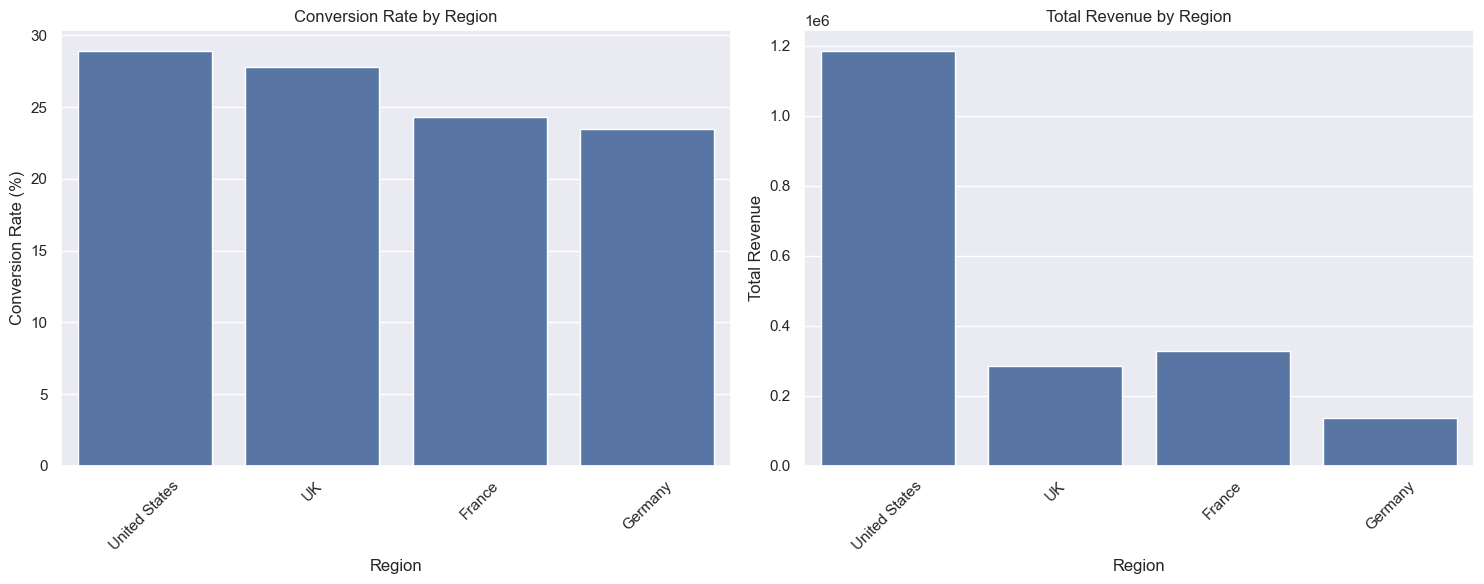

In [61]:
plot = visualize_region_conversion(region_metrics)
plot.show()

In [66]:
df.groupby(['region', 'channel']).size().unstack()

channel,email-рассылки,organic,контекстная реклама,реклама у блогеров,социальные сети
region,,,,,
France,12.0,30.0,43.0,19.0,NaN
Germany,5.0,34.0,44.0,20.0,NaN
UK,7.0,34.0,53.0,23.0,NaN
United States,NaN,249.0,22.0,39.0,375.0


### `Conversion Rates by Region and Channel`

In [129]:
def analyze_region_channel_conversion(df):
    grouped = df.groupby(['region', 'channel'])
    
    region_channel_metrics = pd.DataFrame({
        'total_unique_users': grouped['user_id'].nunique(),
        'unique_paying_users': df[df['payer'] == 1].groupby(['region', 'channel'])['user_id'].nunique()
    }).reset_index()
    
    # Calculate total revenue
    revenue_by_region_channel = df.groupby(['region', 'channel'])['revenue'].sum().reset_index()
    region_channel_metrics = region_channel_metrics.merge(
        revenue_by_region_channel, on=['region', 'channel'], how='left'
    )
    
    # Calculate conversion rate
    region_channel_metrics['conversion_rate'] = (
        region_channel_metrics['unique_paying_users'] / region_channel_metrics['total_unique_users'] * 100
    ).round(1)
    
    # Sort by conversion rate in descending order
    region_channel_metrics = region_channel_metrics.sort_values('conversion_rate', ascending=False)
    
    return region_channel_metrics

# Visualization function
def visualize_region_channel_conversion(region_channel_metrics):
    plt.figure(figsize=(15, 8))
    
    # Create a heatmap of conversion rates
    pivot_conversion = region_channel_metrics.pivot(index='region', columns='channel', values='conversion_rate')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_conversion, annot=True, cmap='YlGnBu', fmt='.1f')
    plt.title('Conversion Rates by Region and Channel')
    plt.xlabel('Channel')
    plt.ylabel('Region')
    plt.tight_layout()
    
    return plt

# Run the analysis
# region_channel_metrics = analyze_region_channel_conversion(df)
# region_channel_metrics
analyze_region_channel_conversion(df_replaced)

,region,channel,total_unique_users,unique_paying_users,revenue,conversion_rate
3,France,реклама у блогеров,19,7,40993,36.8
15,United States,социальные сети,370,113,639887,30.5
7,Germany,реклама у блогеров,20,6,32994,30.0
10,UK,контекстная реклама,51,15,87983,29.4
8,UK,email-рассылки,7,2,9998,28.6
2,France,контекстная реклама,43,12,62988,27.9
13,United States,контекстная реклама,22,6,35994,27.3
0,France,email-рассылки,11,3,22996,27.3
12,United States,organic,248,67,365932,27.0
9,UK,organic,34,9,65991,26.5


<Figure size 1500x800 with 0 Axes>

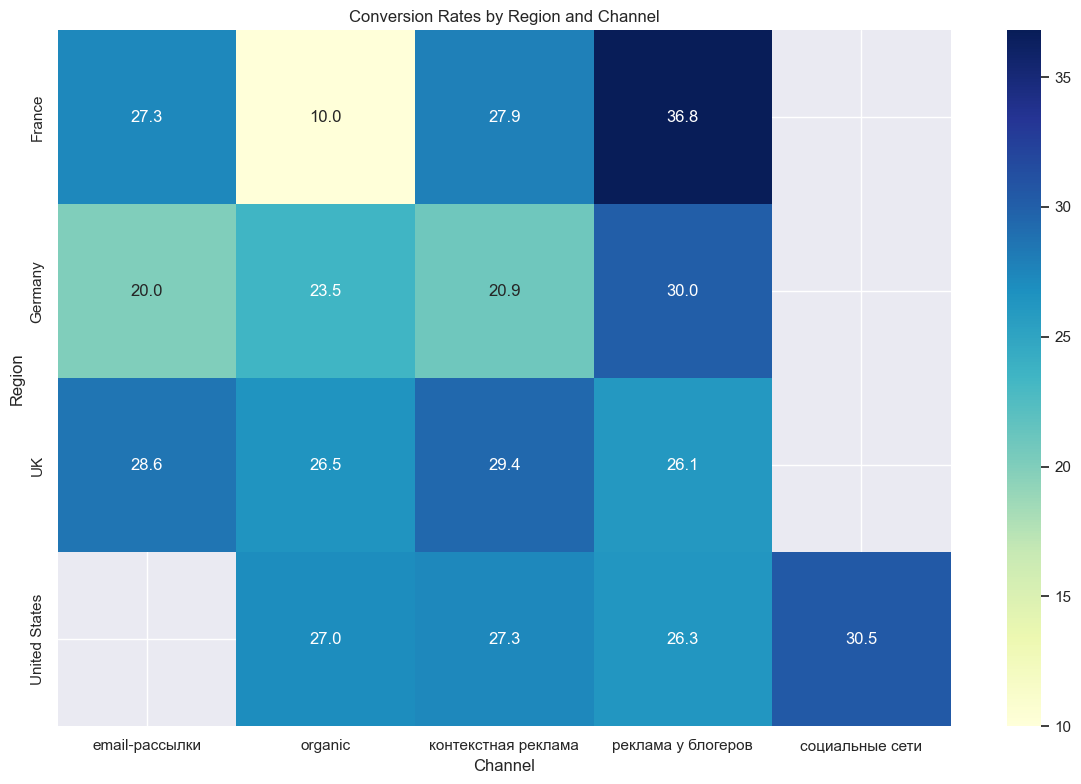

In [73]:
# Visualize
plot = visualize_region_channel_conversion(region_channel_metrics)
plot.show()

In [130]:
def analyze_region_channel_conversion(df):
    grouped = df.groupby(['region', 'channel'])
    
    # Calculate metrics
    region_channel_metrics = pd.DataFrame({
        'total_unique_users': grouped['user_id'].nunique(),
        'unique_paying_users': df[df['payer'] == 1].groupby(['region', 'channel'])['user_id'].nunique()
    }).reset_index()
    
    # Calculate total revenue
    revenue_by_region_channel = df.groupby(['region', 'channel'])['revenue'].sum().reset_index()
    region_channel_metrics = region_channel_metrics.merge(
        revenue_by_region_channel, on=['region', 'channel'], how='left'
    )
    
    # Add channel cost score
    region_channel_metrics['channel_cost_score'] = region_channel_metrics['channel'].map(CHANNEL_COST_HIERARCHY)
    
    # Calculate conversion rate
    region_channel_metrics['conversion_rate'] = (
        region_channel_metrics['unique_paying_users'] / region_channel_metrics['total_unique_users'] * 100
    ).round(1)
    
    # Calculate efficiency score (conversion rate adjusted by channel cost)
    region_channel_metrics['efficiency_score'] = (
        region_channel_metrics['conversion_rate'] / (region_channel_metrics['channel_cost_score'] + 1)
    ).round(2)
    
    # Sort by efficiency score in descending order
    region_channel_metrics = region_channel_metrics.sort_values('efficiency_score', ascending=False)

    return region_channel_metrics

# Run the analysis
region_channel_metrics = analyze_region_channel_conversion(df_replaced)
region_channel_metrics

,region,channel,total_unique_users,unique_paying_users,revenue,channel_cost_score,conversion_rate,efficiency_score
12,United States,organic,248,67,365932,0,27.0,27.00
9,UK,organic,34,9,65991,0,26.5,26.50
5,Germany,organic,34,8,46992,0,23.5,23.50
8,UK,email-рассылки,7,2,9998,1,28.6,14.30
0,France,email-рассылки,11,3,22996,1,27.3,13.65
3,France,реклама у блогеров,19,7,40993,2,36.8,12.27
7,Germany,реклама у блогеров,20,6,32994,2,30.0,10.00
1,France,organic,30,3,21997,0,10.0,10.00
4,Germany,email-рассылки,5,1,4999,1,20.0,10.00
14,United States,реклама у блогеров,38,10,62990,2,26.3,8.77


<Figure size 2000x1000 with 0 Axes>

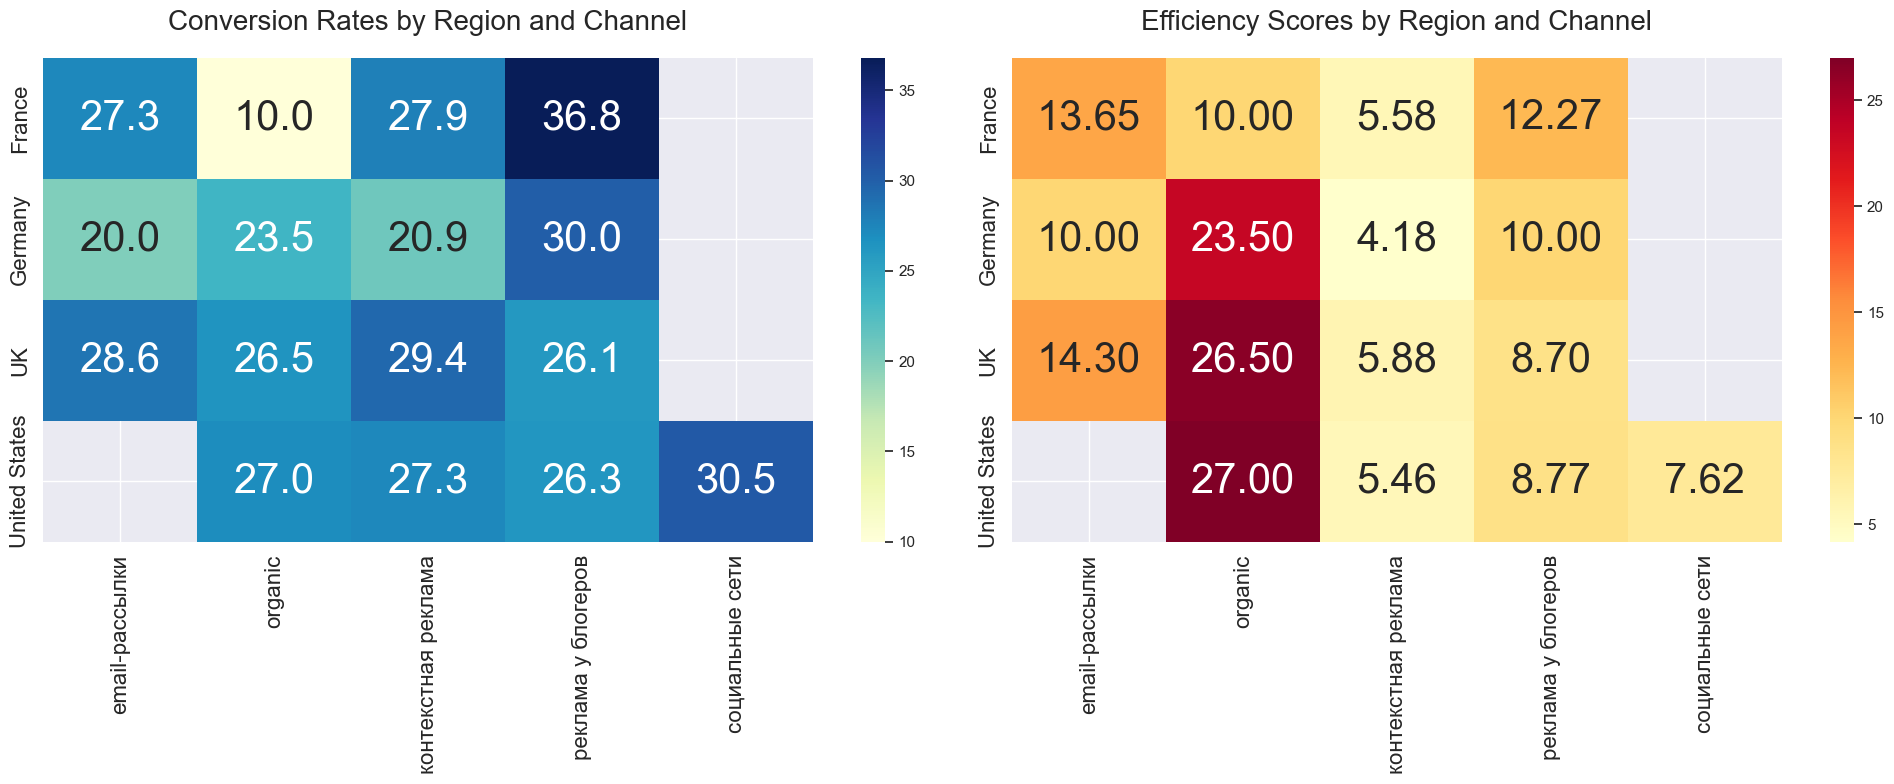

In [106]:
def visualize_region_channel_conversion(region_channel_metrics, fontsize=30):
    plt.figure(figsize=(20, 10))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Conversion Rate Heatmap
    pivot_conversion = region_channel_metrics.pivot(index='region', columns='channel', values='conversion_rate')
    sns.heatmap(pivot_conversion, annot=True, cmap='YlGnBu', fmt='.1f', ax=ax1, annot_kws={"fontsize": fontsize})
    ax1.set_title('Conversion Rates by Region and Channel', fontsize=20, pad=20)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    
    # Efficiency Score Heatmap
    pivot_efficiency = region_channel_metrics.pivot(index='region', columns='channel', values='efficiency_score')
    sns.heatmap(pivot_efficiency, annot=True, cmap='YlOrRd', fmt='.2f', ax=ax2, annot_kws={"fontsize": fontsize})
    ax2.set_title('Efficiency Scores by Region and Channel', fontsize=20, pad=20)
    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    return plt

plot = visualize_region_channel_conversion(region_channel_metrics)
plt.savefig(fname=f'conversion_rate.png', format='png', bbox_inches='tight', dpi=300)
plot.show()

In [111]:
df.groupby(['channel']).size()

channel
email-рассылки          24
organic                347
контекстная реклама    162
реклама у блогеров     101
социальные сети        375
dtype: int64

<Axes: xlabel='channel', ylabel='region'>

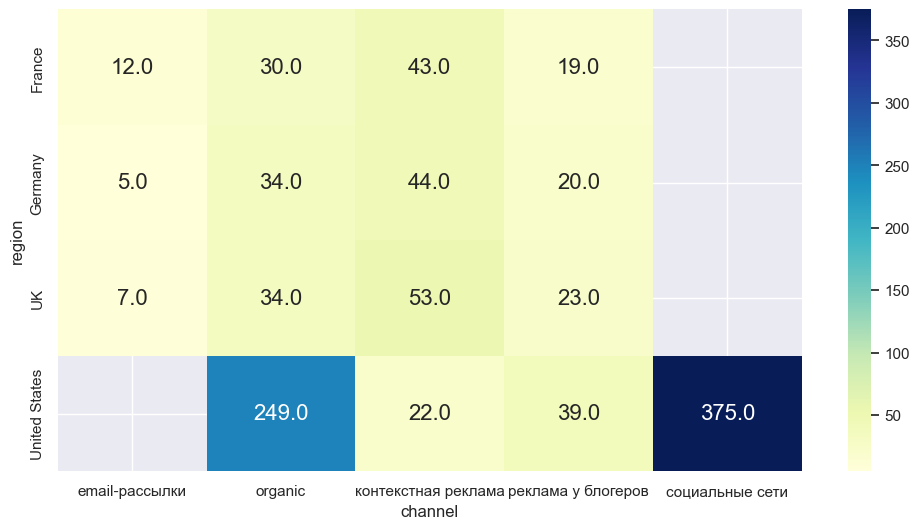

In [124]:
pivot = df.groupby(['region', 'channel']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.1f', annot_kws={"fontsize": 16})

In [122]:
pivot

channel,email-рассылки,organic,контекстная реклама,реклама у блогеров,социальные сети
region,,,,,
France,12.0,30.0,43.0,19.0,NaN
Germany,5.0,34.0,44.0,20.0,NaN
UK,7.0,34.0,53.0,23.0,NaN
United States,NaN,249.0,22.0,39.0,375.0
